# Multinomial regression

In this notebook we perform multinomial / softmax resression

### Import functions

In [1]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, cross_entropy_loss_method, predict, accuracy_func
from Code.descent_methods import SGD_adam
from Code.data_handling import load_MNIST_8, load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model
from Code.plot import *

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Set filename start. Create the folder if gone
filepath_location = "Figures/a/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download the data

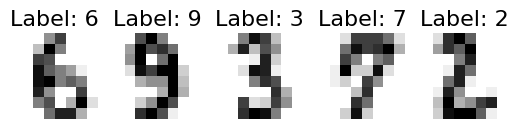

In [2]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)
X_train, y_train, X_test, y_test = load_MNIST_8(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

### Single run

100%|██████████| 100/100 [00:01<00:00, 60.98it/s]


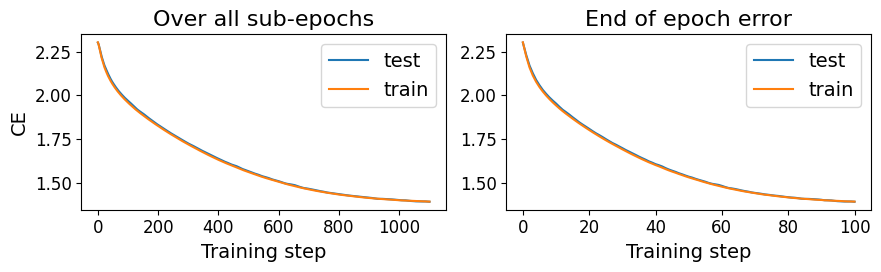

test:  0.9080780148506165
train:  0.9137691259384155
CE test:  1.3913939
CE train:  1.3922604


In [3]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, epochs=300, batch_size=32, 
               plot_or_not=False, result_filepath=None, store_params=False, 
               intermediate_epochs=None):
    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    beta0 = softmax_beta_init(input_shape=X_train.shape[1], output_shape=y_train.shape[1])
    model = softmax_model

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    loss_func = jit(cross_entropy_loss_method(model=model, lam=lam))
    loss_grad = jit(grad(loss_func))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(MSELoss_method(model))
        test_func = loss_func
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        n_batches = int(y_train.shape[0] / batch_size)
        plot_test_results(result["test_loss_list"], result["train_loss_list"], n_batches, ylabel="CE")

    # Add accuracy scores
    result["test_accuracy"]  = accuracy_func(model, result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_func(model, result["beta_final"], X_train, y_train)
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : accuracy_func(model, be, X_test, y_test), 
                                  "train_accuracy"    : accuracy_func(model, be, X_train, y_train),
                                  "lr"                : lr, 
                                  "lam"               : lam,
                                  "epochs"            : ie,
                                  "batch_size"        : batch_size}
                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "lr"                : lr, 
                          "lam"               : lam,
                          "epochs"            : epochs,
                          "batch_size"        : batch_size}
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}
        append_run_to_file(result_filepath, _dict_to_store)

    return result

## A demonstration
epochs = 100
batch_size = 128 # 1024
lr = 0.01 # 0.01
result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=0.0001, epochs=epochs, batch_size=batch_size,
                    plot_or_not=True, result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

### Learning rate, batch size and epoch number

In [12]:
batch_sizes           = [32, 64, 128, 256, 512, 1028]
learning_rates        = [0.001, 0.005, 0.01, 0.02]
regularisation_params = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

# We do one run with max epoch number, storing the intermediate as their own runs
epoch_numbers = [25, 50, 75, 100]


# result_filepath = "Results/multinomial_28.json"
result_filepath = "Results/multinomial_8.json"

# Perform the #b*#l*#e experiments
for b in batch_sizes:
    for l in learning_rates:
        for r in regularisation_params:
            print(f"Batch Size: {b}, Learning Rate: {l}, Regularisation: {r}")

            result = single_run(X_train, X_test, y_train, y_test, 
                                lr=l, lam=r, epochs=epoch_numbers[-1], batch_size=b,
                                plot_or_not=False, result_filepath=result_filepath, intermediate_epochs=epoch_numbers[0:-1])

Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 100/100 [00:02<00:00, 45.87it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 100/100 [00:02<00:00, 45.07it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 100/100 [00:02<00:00, 46.00it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 100/100 [00:02<00:00, 45.07it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 100/100 [00:02<00:00, 46.64it/s]


Batch Size: 32, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 100/100 [00:02<00:00, 43.55it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 100/100 [00:02<00:00, 45.41it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 100/100 [00:02<00:00, 46.27it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 100/100 [00:02<00:00, 45.74it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 100/100 [00:02<00:00, 46.45it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 100/100 [00:02<00:00, 44.46it/s]


Batch Size: 32, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 100/100 [00:02<00:00, 46.07it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 100/100 [00:02<00:00, 43.83it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 100/100 [00:02<00:00, 45.25it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.001


100%|██████████| 100/100 [00:02<00:00, 45.57it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 0.0001


100%|██████████| 100/100 [00:02<00:00, 46.42it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 1e-05


100%|██████████| 100/100 [00:02<00:00, 45.92it/s]


Batch Size: 32, Learning Rate: 0.01, Regularisation: 1e-06


100%|██████████| 100/100 [00:02<00:00, 42.55it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.1


100%|██████████| 100/100 [00:02<00:00, 45.36it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.01


100%|██████████| 100/100 [00:02<00:00, 44.82it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.001


100%|██████████| 100/100 [00:02<00:00, 46.57it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 0.0001


100%|██████████| 100/100 [00:02<00:00, 45.64it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 1e-05


100%|██████████| 100/100 [00:02<00:00, 42.66it/s]


Batch Size: 32, Learning Rate: 0.02, Regularisation: 1e-06


100%|██████████| 100/100 [00:02<00:00, 45.78it/s]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.1


100%|██████████| 100/100 [00:01<00:00, 72.16it/s]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.01


100%|██████████| 100/100 [00:01<00:00, 70.70it/s]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.001


100%|██████████| 100/100 [00:01<00:00, 71.48it/s]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 0.0001


100%|██████████| 100/100 [00:01<00:00, 71.33it/s]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 1e-05


100%|██████████| 100/100 [00:01<00:00, 71.94it/s]


Batch Size: 64, Learning Rate: 0.001, Regularisation: 1e-06


100%|██████████| 100/100 [00:01<00:00, 66.09it/s]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.1


100%|██████████| 100/100 [00:01<00:00, 71.37it/s]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.01


100%|██████████| 100/100 [00:01<00:00, 69.64it/s]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.001


100%|██████████| 100/100 [00:01<00:00, 72.61it/s]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 0.0001


100%|██████████| 100/100 [00:01<00:00, 73.46it/s]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 1e-05


100%|██████████| 100/100 [00:01<00:00, 71.26it/s]


Batch Size: 64, Learning Rate: 0.005, Regularisation: 1e-06


100%|██████████| 100/100 [00:01<00:00, 72.78it/s]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 0.1


100%|██████████| 100/100 [00:01<00:00, 70.47it/s]


Batch Size: 64, Learning Rate: 0.01, Regularisation: 0.01


100%|██████████| 100/100 [00:01<00:00, 72.75it/s]


In [5]:


data = {
    "Epochs": [10, 20, 30, 40, 59, 40, 59],
    "Batch size": [8, 16, 32, 64, 54, 40, 59],
    "Learning rate": [0.01, 0.01, 0.02, 0.03, 0.07, 0.003, 0.002],
    "Regularisation": [0.1, 0.01, 0.02, 0.03, 0.07, 0.03, 0.04],
    "Accuracy": [1, 0.9, 0.8, 0.7, 0.4, 1, 1],
}

plot_grid_search_result(data)


### Final model evaluation

100%|██████████| 100/100 [00:02<00:00, 41.50it/s]


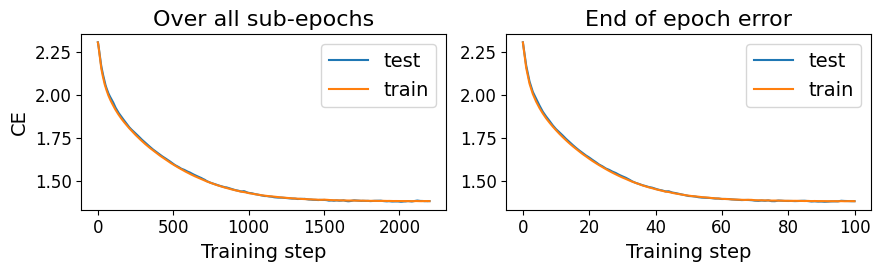

In [6]:
l = 0.01
e = 100
b = 64

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=l, lam=0.0001, epochs=e, batch_size=b,
                    plot_or_not=True, result_filepath=result_filepath)

model = result["model"]
beta = result["beta_final"]

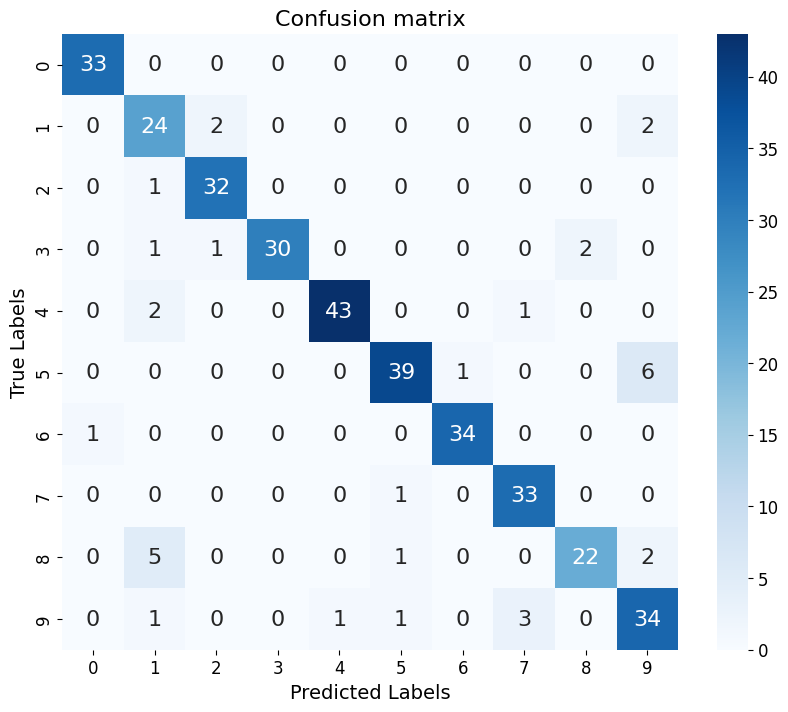

In [7]:
plot_confusion_matrix(X_test, y_test, model, beta,
                      convert_to_percent=False, 
                      filename=filepath_location + "confusion") 

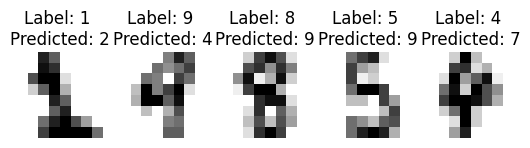

In [8]:
plot_faulty_predictions(X_test, y_test, model, beta)

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:174: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



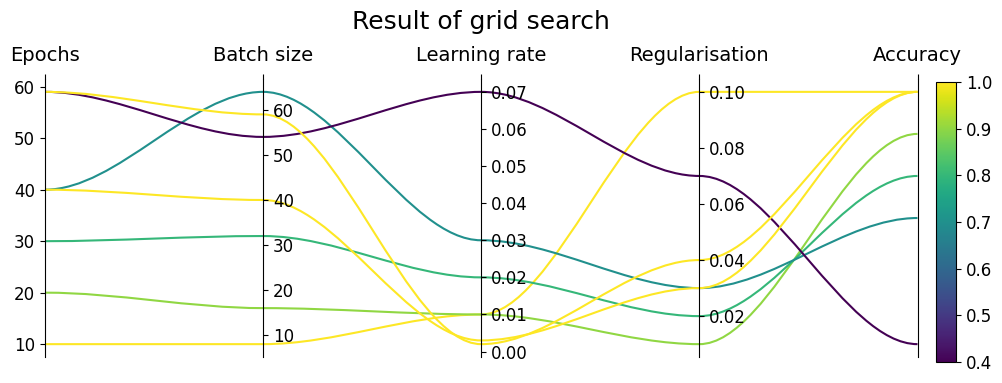

In [10]:
data = {
    "Epochs": [10, 20, 30, 40, 59, 40, 59],
    "Batch size": [8, 16, 32, 64, 54, 40, 59],
    "Learning rate": [0.01, 0.01, 0.02, 0.03, 0.07, 0.003, 0.002],
    "Regularisation": [0.1, 0.01, 0.02, 0.03, 0.07, 0.03, 0.04],
    "Accuracy": [1, 0.9, 0.8, 0.7, 0.4, 1, 1],
}

plot_grid_search_result(data)